In [2]:
import numpy as np

def chirpgeneration(dataX, snr, qcCoefs):
    """
    Generate a quadratic chirp signal
    
    Example usage:
    >>> dataX = np.linspace(0, 1, 1000)
    >>> snr = 10
    >>> qcCoefs = [1, 0.5, 0.1]
    >>> sigVec = chirpgeneration(dataX, snr, qcCoefs)

    Parameters:
    -----------
    dataX : array-like
        Vector of time stamps at which the samples of the signal are to be computed
    snr : float
        Matched filtering signal-to-noise ratio
    qcCoefs : array-like
        Vector of three coefficients [a1, a2, a3] that parametrize the phase 
        of the signal: a1*t + a2*t^2 + a3*t^3
    
    Returns:
    --------
    sigVec : numpy.ndarray
        Vector of samples of the generated quadratic chirp signal

    %Clara Liu, August 2025
    """
    # Convert inputs to numpy arrays for element-wise operations
    dataX = np.array(dataX)
    qcCoefs = np.array(qcCoefs)
    
    # Calculate phase vector: a1*t + a2*t^2 + a3*t^3
    phaseVec = qcCoefs[0] * dataX + qcCoefs[1] * dataX**2 + qcCoefs[2] * dataX**3
    
    # Generate the signal using sine function
    sigVec = np.sin(2 * np.pi * phaseVec)
    
    # Normalize and scale by SNR
    sigVec = snr * sigVec / np.linalg.norm(sigVec)
    
    return sigVec

Generated signal with 3577 samples
Signal norm: 10.0000
Sampling frequency: 1192.00 Hz
Max instantaneous frequency: 298.00 Hz


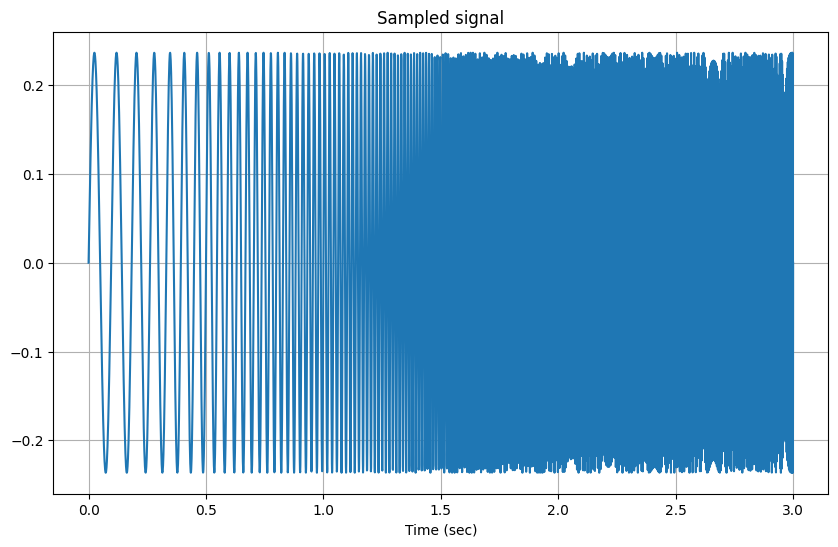

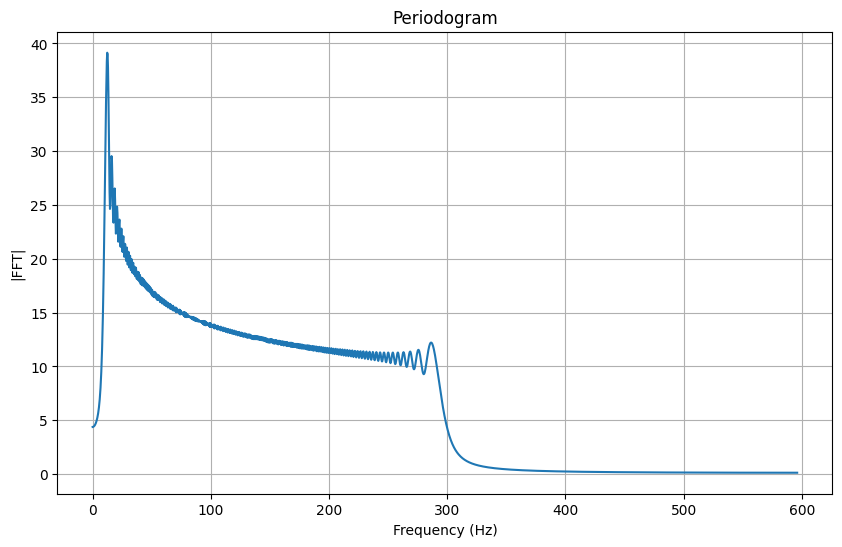

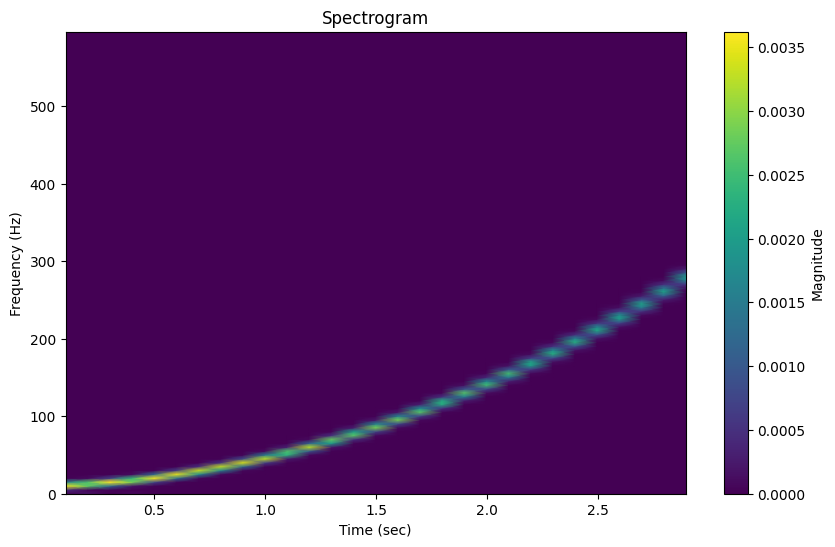

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram


'Generate the signal------------'
# Signal parameters of the quadratic chirp signal
a1 = 10 
a2 = 3
a3 = 10
A = 10 # SNR

# Setting appropriate sampling frequency
duration = 3.0  # Pre-set the duration of the signal (sec)
maxFreq = a1 + 2 * a2 * duration + 3 * a3 * duration**2 # Maximum instantaneous frequency
nyqFreq = 2 * maxFreq # Nyquist frequency
samplFreq = 2 * nyqFreq # Sampling frequency
samplIntrvl = 1 / samplFreq # Sampling interval

# Time samples
timeVec = np.arange(0, duration + samplIntrvl, samplIntrvl)
# Number of samples
nSamples = len(timeVec)

# Generate the signal
sigVec = chirpgeneration(timeVec, A, [a1, a2, a3])
# the information of the generated signal
print(f"Generated signal with {len(sigVec)} samples")
print(f"Signal norm: {np.linalg.norm(sigVec):.4f}")
print(f"Sampling frequency: {samplFreq:.2f} Hz")
print(f"Max instantaneous frequency: {maxFreq:.2f} Hz")


'Plot the time-domain signal------------'
plt.figure(figsize=(10, 6))
plt.plot(timeVec, sigVec, markersize=8)
plt.xlabel('Time (sec)')
plt.title('Sampled signal')
plt.grid(True)
plt.show()


'Plot the frequency-domain signal (periodogram)------------'
# Calculate the positive Fourier frequencies
dataLen = timeVec[-1] - timeVec[0] # Duration of the signal (sec)
kNyq = int(np.floor(nSamples/2)) + 1 # Index of DFT sample corresponding to Nyquist frequency
posFreq = np.arange(0, kNyq) * (1/dataLen) ## Positive Fourier frequencies, where f(HZ) = k / T(sec)

# Compute the FFT of the signal
fftSig = np.fft.fft(sigVec)
fftSig = fftSig[:kNyq]# Discard negative frequencies

# Plot periodogram
plt.figure(figsize=(10, 6))
plt.plot(posFreq, np.abs(fftSig))
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT|')
plt.title('Periodogram')
plt.grid(True)
plt.show()


'Plot a spectrogram------------'
# Spectrogram parameters
winLen = 0.2  # sec
ovrlp = 0.1  # sec
winLenSmpls = int(np.floor(winLen * samplFreq))# Convert to integer number of samples
ovrlpSmpls = int(np.floor(ovrlp * samplFreq))

# Compute the spectrogram and plot
f, t, Sxx = spectrogram(sigVec, fs=samplFreq, window='hann', 
                        nperseg=winLenSmpls, noverlap=ovrlpSmpls)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()


In [4]:
import numpy as np
from IPython.display import Audio, display

'Play the audio of the generated signal------------'

# Signal parameters of the quadratic chirp signal
a1 = 100 
a2 = 50
a3 = 25
A = 0.5 # SNR

# Setting appropriate sampling frequency
duration = 2.0  # Pre-set the duration of the signal (sec)
maxFreq = a1 + 2 * a2 * duration + 3 * a3 * duration**2 # Maximum instantaneous frequency(need to be constrain from 20 Hz to 20,000 Hz)
nyqFreq = 2 * maxFreq # Nyquist frequency
samplFreq = max(16000, int(2 * nyqFreq))  # Sampling frequency is at least 16kHz or 2x nyqFreq 
samplIntrvl = 1 / samplFreq # Sampling interval

# Time samples
timeVec = np.arange(0, duration + samplIntrvl, samplIntrvl)
# Number of samples
nSamples = len(timeVec)

# Generate the signal
sigVec = chirpgeneration(timeVec, A, [a1, a2, a3])

#Play the audio of the generated signal
print("🎵 Play the audio of the generated quadratic chirp signal")
signal_normalized = np.clip(sigVec, -1.0, 1.0)
audio_widget = Audio(signal_normalized, rate=samplFreq, autoplay=True)
display(audio_widget)

# Print signal information
print(f"Generated signal with {len(sigVec)} samples")
print(f"Sampling frequency: {samplFreq:.2f} Hz")
print(f"Max instantaneous frequency: {maxFreq:.2f} Hz")

🎵 Play the audio of the generated quadratic chirp signal


Generated signal with 32001 samples
Sampling frequency: 16000.00 Hz
Max instantaneous frequency: 600.00 Hz


The maximum frequency of the quadratic chirp is 149.87 Hz
Filtered signal length: 2048
Original signal length: 2048


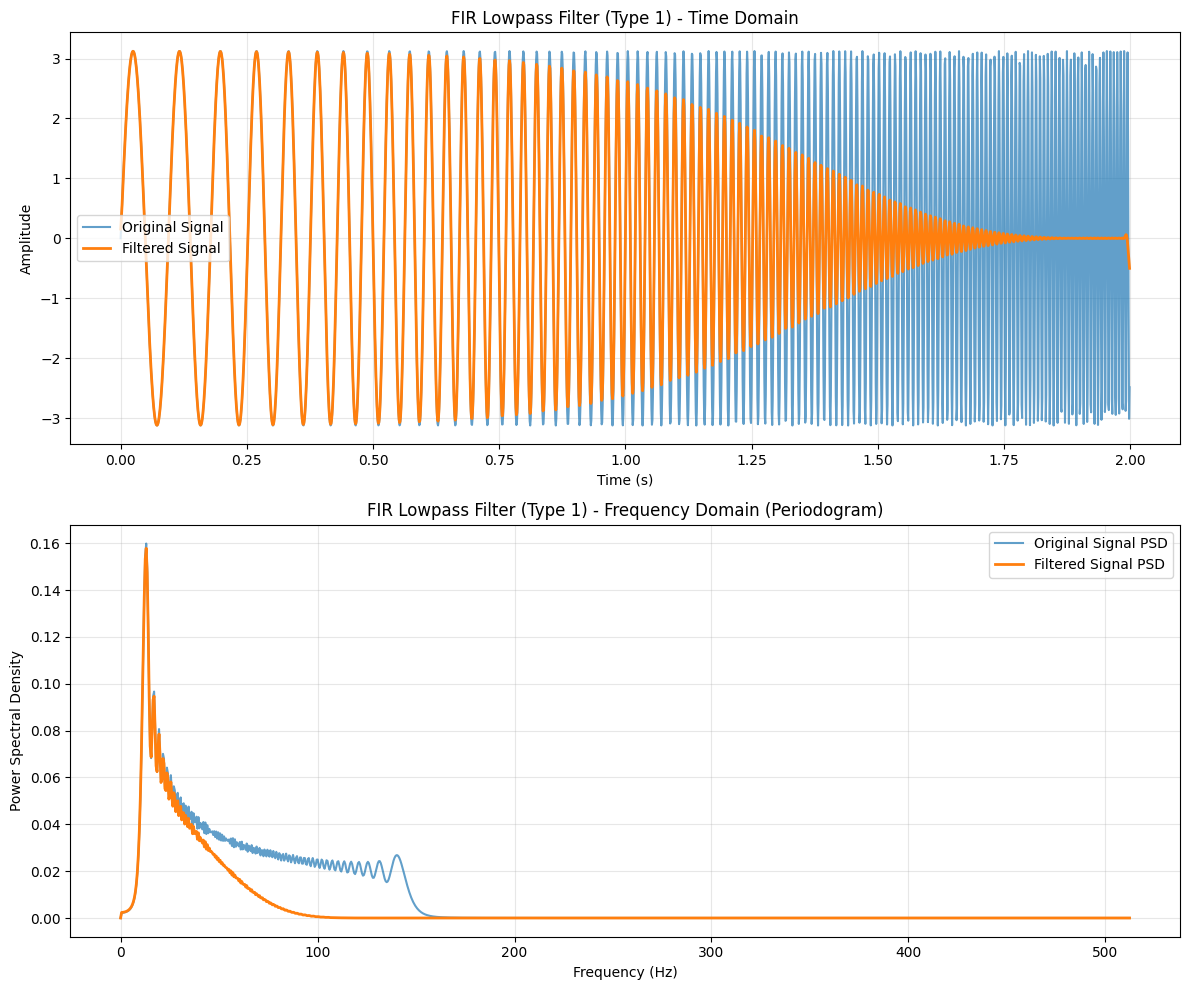

Filtered signal length: 2048
Original signal length: 2048


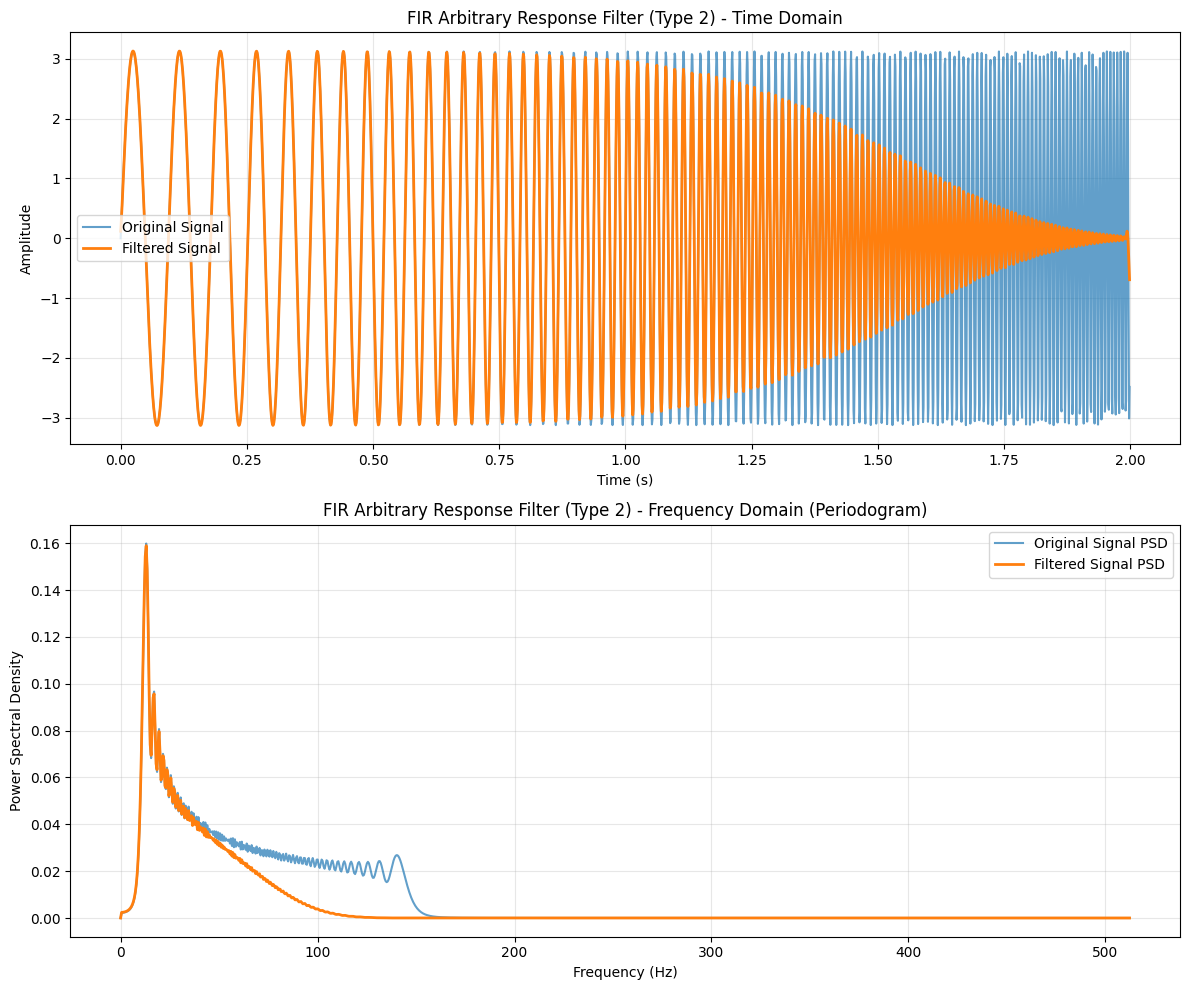

Filtered signal length: 2048
Original signal length: 2048


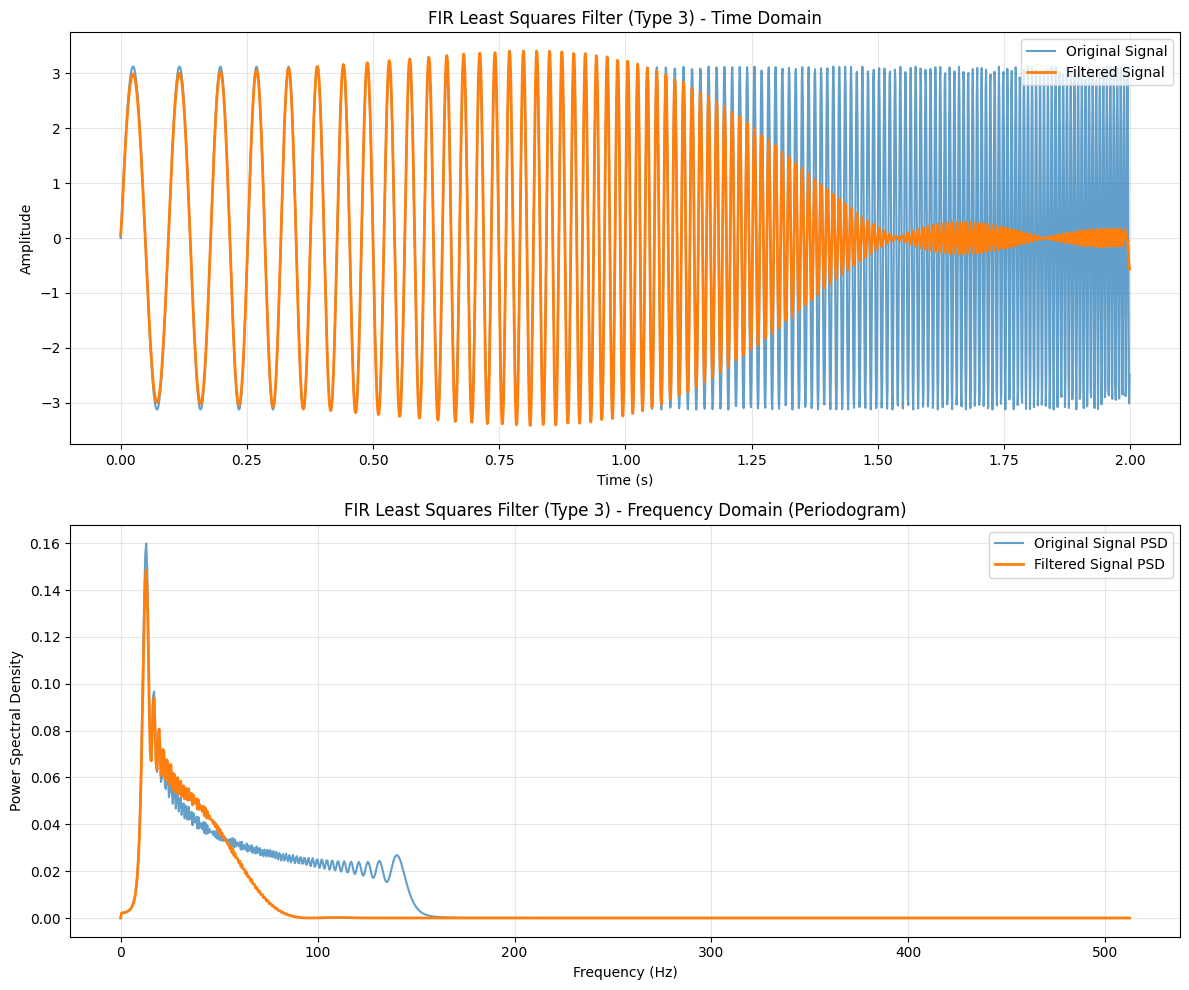

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

'Design and apply FIR filters to the generated signal------------'

def plot_filter_with_periodogram(time_vec, sig, filter_coeff, filter_name="Filter"):
    # Apply filter using FFT-based convolution
    filt_sig = signal.fftconvolve(sig, filter_coeff, mode='same')
    
    # Calculate periodograms
    freq_orig, psd_orig = signal.periodogram(sig, fs=len(sig)/time_vec[-1])
    freq_filt, psd_filt = signal.periodogram(filt_sig, fs=len(sig)/time_vec[-1])
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Time domain plot
    ax1.plot(time_vec, sig, label='Original Signal', alpha=0.7)
    ax1.plot(time_vec, filt_sig, label='Filtered Signal', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'{filter_name} - Time Domain')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Frequency domain plot (Periodogram)
    ax2.plot(freq_orig, psd_orig, label='Original Signal PSD', alpha=0.7)
    ax2.plot(freq_filt, psd_filt, label='Filtered Signal PSD', linewidth=2)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power Spectral Density')
    ax2.set_title(f'{filter_name} - Frequency Domain (Periodogram)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # ax2.set_xlim(0, freq_orig[-1]/4)  # Show up to 1/4 of max frequency for better visualization
    
    plt.tight_layout()
    plt.show()
    
    return filt_sig

# Low pass filter demo
samp_freq = 1024
n_samples = 2048
time_vec = np.arange(n_samples) / samp_freq

# Quadratic chirp signal parameters
a1 = 10
a2 = 5
a3 = 10
A = 100

# Signal length
sig_len = (n_samples - 1) / samp_freq  # Duration of the signal in seconds

# Maximum frequency
max_freq = a1 + 2*a2*sig_len + 3*a3*sig_len**2
print(f'The maximum frequency of the quadratic chirp is {max_freq:.2f} Hz')

# Generate signal
sig_vec = chirpgeneration(time_vec, A, [a1, a2, a3])

# Filter parameters
filt_order = 30

# Filter type 1 - Standard FIR lowpass
a = signal.firwin(filt_order + 1, max_freq/2, fs=samp_freq, 
                  width=None, window='hamming', pass_zero='lowpass')
p=plot_filter_with_periodogram(time_vec, sig_vec, a, "FIR Lowpass Filter (Type 1)")

# Filter type 2 - Arbitrary frequency response
freq = [0, max_freq/4, max_freq/2, 3*max_freq/4, samp_freq/2]
gain = [1, 1, 1, 0, 0]
b = signal.firwin2(filt_order + 1, freq, gain, fs=samp_freq)
p=plot_filter_with_periodogram(time_vec, sig_vec, b, "FIR Arbitrary Response Filter (Type 2)")

# Filter type 3 - Least squares design
bands = [0, max_freq/2, max_freq/2, samp_freq/2]
desired = [1, 1, 0, 0]
c = signal.firls(filt_order + 1, bands, desired, fs=samp_freq)
p=plot_filter_with_periodogram(time_vec, sig_vec, c, "FIR Least Squares Filter (Type 3)")
